In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 128
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U = 0.5
hami = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [8]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

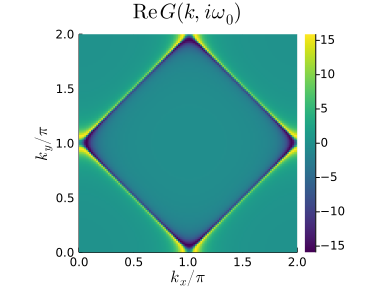

In [9]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

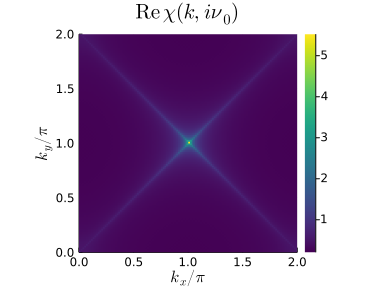

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [11]:
smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

┌ Warning: Sampling matrix is poorly conditioned (cond = 1.065147976453173e16).
└ @ SparseIR /home/kosuke/.julia/packages/SparseIR/hZp6V/src/sampling.jl:64


In [29]:
chisf = chiskf[:,nsize÷2+1, nsize÷2+1]
deleteat!(chisf, hnw+1)
chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
#chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

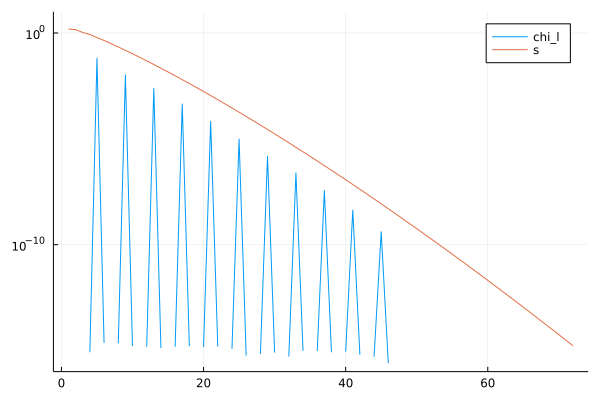

In [47]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [13]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

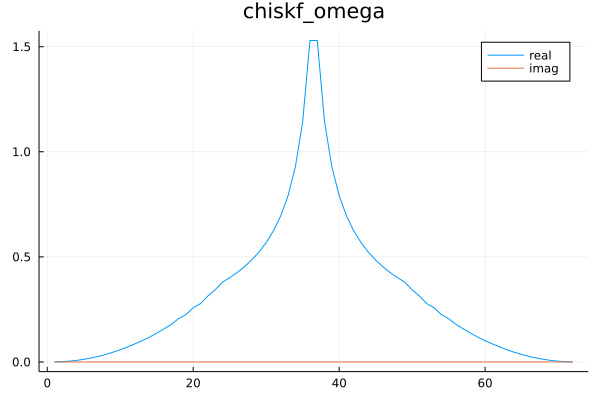

In [14]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

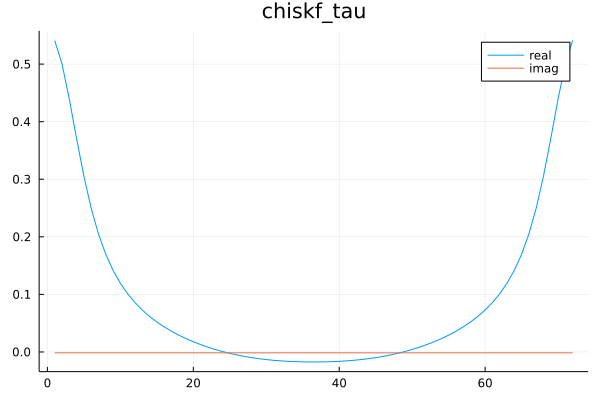

In [15]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [16]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

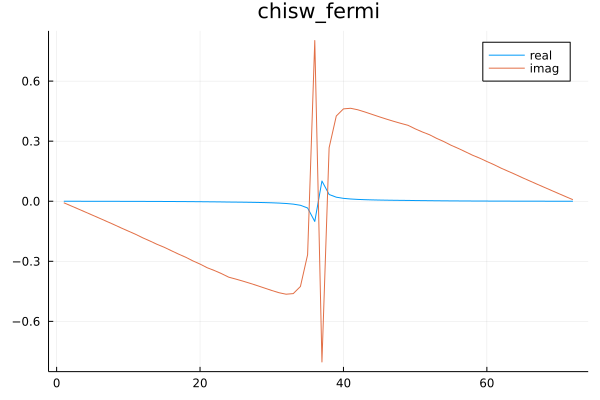

In [17]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [18]:
sum = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

1.1024678301380864

In [19]:
setprecision(512)

512

In [20]:
input_chi  = Array{Complex{T}}(undef, hnw-1) 
input_smpl = Array{Complex{T}}(undef, hnw-1) 
;

In [21]:
for i in 1:hnw-1
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+1+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+1+i]
end

In [22]:
N_real    =  10000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw-1, input_smpl, input_chi)
N_imag = hnw - 1
println("N_imag $(N_imag)")

N_imag is setted as 2
N_imag 35


In [23]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is non positive semi-definite matrix in Schur method.
H=1
Iter     Function value   Gradient norm 
     0     1.769318e+01     3.797766e+01
 * time: 0.019609928131103516
     1     1.628350e+01     5.790218e+00
 * time: 9.164506912231445
     2     1.385500e+01     3.293329e+00
 * time: 12.945351123809814
     3     1.379626e+01     1.444349e+00
 * time: 15.464033126831055
     4     1.379260e+01     4.462111e-01
 * time: 18.20793104171753
     5     1.379209e+01     2.866527e-01
 * time: 20.684672117233276
     6     1.379188e+01     1.495699e-01
 * time: 26.01640796661377
     7     1.379183e+01     6.605095e-02
 * time: 28.731082916259766
     8     1.379182e+01     3.516357e-02
 * time: 32.78108596801758
     9     1.379182e+01     2.005723e-02
 * time: 36.07876992225647
    10     1.379182e+01     1.044121e-02
 * time: 39.119548082351685
    11     1.379182e+01     5.013269e-03
 * time: 41.98759412765503
    12     1.379182e+01     3.006140e-03
 * time: 46.243465900421

In [24]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     1.379182e+01     6.883822e-09
 * time: 0.0002129077911376953
max_theta=0.350406809412859101392831230690748568201062876024292123484315805042016794892756717228003382219753121039158647537028574109124899063978353859284773454506151536
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.379182e+01     5.891720e+00
 * time: 0.0001850128173828125
     1     1.375492e+01     5.279398e+00
 * time: 9.664423942565918
     2     1.305051e+01     8.813030e+00
 * time: 18.921267986297607
     3     1.171544e+01     1.026232e+01
 * time: 25.293790102005005
     4     1.141830e+01     7.081401e+00
 * time: 29.3939790725708
     5     1.063703e+01     3.858352e+00
 * time: 33.63749289512634
     6     1.039422e+01     2.945795e+00
 * time: 36.567320108413696
     7     1.006544e+01     2.294961e+00
 * time: 39.3383948802948
     8     1.001955e+01     4.560565e+00
 * time: 43.76891303062439
     9     9.981418e

     4     7.451847e+00     3.125498e+00
 * time: 37.798725843429565
     5     7.243830e+00     2.508556e+00
 * time: 46.62600803375244
     6     7.021070e+00     3.019677e+00
 * time: 51.46057391166687
     7     6.696912e+00     3.335565e+00
 * time: 58.39048194885254
     8     6.505481e+00     3.397941e+00
 * time: 66.66460990905762
     9     6.200083e+00     3.471136e+00
 * time: 73.96659088134766
    10     6.056248e+00     3.474866e+00
 * time: 79.7304949760437
    11     5.919725e+00     2.646342e+00
 * time: 86.63337898254395
    12     5.781928e+00     1.761284e+00
 * time: 93.06531000137329
    13     5.721283e+00     2.185768e+00
 * time: 99.69723296165466
    14     5.692203e+00     1.299679e+00
 * time: 103.4314489364624
    15     5.644551e+00     1.098073e+00
 * time: 106.79342484474182
    16     5.591834e+00     7.896360e-01
 * time: 111.88975191116333
    17     5.572094e+00     4.279110e-01
 * time: 115.74427390098572
    18     5.560036e+00     1.196342e+00
 * t

    44     3.875073e+00     1.538954e-05
 * time: 241.37906408309937
    45     3.875073e+00     1.108459e-05
 * time: 245.12809109687805
    46     3.875073e+00     7.971083e-06
 * time: 248.69401717185974
    47     3.875073e+00     7.272081e-06
 * time: 252.20437097549438
    48     3.875073e+00     3.562793e-06
 * time: 256.6117000579834
    49     3.875073e+00     2.602807e-06
 * time: 260.1431050300598
    50     3.875073e+00     1.972291e-06
 * time: 263.69360399246216
    51     3.875073e+00     3.103959e-06
 * time: 267.2403609752655
    52     3.875073e+00     3.003159e-06
 * time: 270.6935341358185
    53     3.875073e+00     2.972950e-06
 * time: 274.92802810668945
    54     3.875073e+00     2.301350e-06
 * time: 278.5700960159302
    55     3.875073e+00     2.073419e-06
 * time: 282.1489100456238
    56     3.875073e+00     1.704248e-06
 * time: 286.5768630504608
    57     3.875073e+00     1.662773e-06
 * time: 290.4224531650543
    58     3.875073e+00     1.430762e-06
 

    81     2.189820e+00     5.419243e-06
 * time: 422.67476511001587
    82     2.189820e+00     5.670652e-06
 * time: 426.24104714393616
    83     2.189820e+00     5.219422e-06
 * time: 429.8213701248169
    84     2.189820e+00     5.451075e-06
 * time: 433.90377402305603
    85     2.189820e+00     4.583674e-06
 * time: 438.7794680595398
    86     2.189820e+00     4.124549e-06
 * time: 442.96397709846497
    87     2.189820e+00     3.140103e-06
 * time: 446.75126099586487
    88     2.189820e+00     3.089468e-06
 * time: 451.2075080871582
    89     2.189820e+00     1.853417e-06
 * time: 454.7026960849762
    90     2.189820e+00     1.848113e-06
 * time: 458.77383303642273
    91     2.189820e+00     1.158236e-06
 * time: 463.20360803604126
    92     2.189820e+00     1.032753e-06
 * time: 467.2025661468506
    93     2.189820e+00     6.397582e-07
 * time: 470.77792501449585
    94     2.189820e+00     6.066579e-07
 * time: 474.2605781555176
    95     2.189820e+00     3.590185e-07

    85     1.428592e+00     6.806219e-07
 * time: 454.73881006240845
    86     1.428592e+00     2.282488e-07
 * time: 460.1071720123291
    87     1.428592e+00     3.397881e-07
 * time: 465.4648139476776
    88     1.428592e+00     2.315493e-07
 * time: 469.77150106430054
    89     1.428592e+00     2.032333e-07
 * time: 473.721538066864
    90     1.428592e+00     1.696876e-07
 * time: 477.73595118522644
    91     1.428592e+00     1.480539e-07
 * time: 482.0012881755829
    92     1.428592e+00     1.118543e-07
 * time: 485.80811405181885
    93     1.428592e+00     9.394601e-08
 * time: 490.2307300567627
    94     1.428592e+00     6.826447e-08
 * time: 495.043151140213
    95     1.428592e+00     5.067034e-08
 * time: 499.56738209724426
    96     1.428592e+00     3.594988e-08
 * time: 503.70648217201233
    97     1.428592e+00     2.455060e-08
 * time: 508.8714499473572
    98     1.428592e+00     1.566872e-08
 * time: 513.1346700191498
    99     1.428592e+00     1.141563e-08
 * 

   101     7.274553e-01     2.577577e-04
 * time: 561.0763688087463
   102     7.274553e-01     1.685739e-04
 * time: 565.3963828086853
   103     7.274553e-01     9.570619e-05
 * time: 569.6800107955933
   104     7.274553e-01     1.219331e-04
 * time: 574.5414497852325
   105     7.274553e-01     5.839365e-05
 * time: 579.49453997612
   106     7.274553e-01     1.531791e-04
 * time: 583.9247829914093
   107     7.274553e-01     1.031863e-04
 * time: 589.0637609958649
   108     7.274553e-01     1.479949e-04
 * time: 593.4020500183105
   109     7.274553e-01     8.886432e-05
 * time: 597.7658989429474
   110     7.274553e-01     9.590096e-05
 * time: 601.9802618026733
   111     7.274553e-01     5.542369e-05
 * time: 606.3661539554596
   112     7.274553e-01     5.537412e-05
 * time: 612.3716609477997
   113     7.274553e-01     4.660324e-05
 * time: 617.4072439670563
   114     7.274553e-01     5.247308e-05
 * time: 622.0246839523315
   115     7.274553e-01     3.922522e-05
 * time: 

    67     5.906352e-01     2.505638e-03
 * time: 436.7038128376007
    68     5.906347e-01     7.428050e-04
 * time: 440.9210138320923
    69     5.906343e-01     7.320190e-04
 * time: 448.14130187034607
    70     5.906340e-01     4.005349e-04
 * time: 452.4675340652466
    71     5.906338e-01     4.608205e-04
 * time: 459.8970079421997
    72     5.906337e-01     2.750557e-04
 * time: 464.31045484542847
    73     5.906337e-01     2.481066e-04
 * time: 470.7139780521393
    74     5.906336e-01     3.031532e-04
 * time: 478.2115080356598
    75     5.906336e-01     1.316485e-04
 * time: 484.7608289718628
    76     5.906336e-01     3.111343e-04
 * time: 493.31082105636597
    77     5.906336e-01     1.141014e-04
 * time: 497.8305039405823
    78     5.906336e-01     1.055910e-04
 * time: 502.164892911911
    79     5.906336e-01     7.913632e-05
 * time: 506.6738078594208
    80     5.906336e-01     6.376982e-05
 * time: 511.8831079006195
    81     5.906336e-01     3.447121e-05
 * ti

In [25]:
#imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, hnw-1)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is non positive semi-definite matrix in Schur method.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

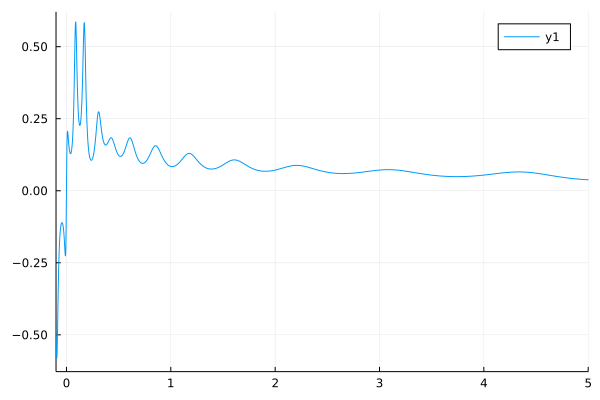

In [26]:
plot(xlim = [-0.1,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

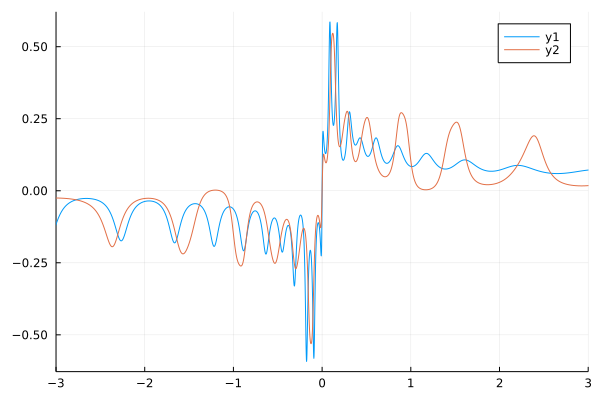

In [27]:
plot(xlim = [-3,3])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*0.1*real.(sol.reals.freq)))

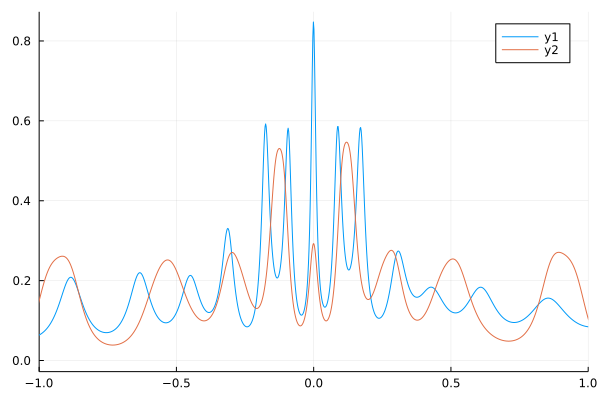

In [28]:
plot(xlim = [-1,1])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))